# Applying dimensionality reduction techniques on SDSS APOGEE data (high resolution) to separate stellar populations

For this project, I have have selected every 1000th spectra from the SDSS 18th data release. The first part of the notebook uses the mjd, fiber and plate to download fits file from sdss server and appends their corresponding g-r values. Once that's done, to make sure my data points are all in the same place, I take the bins of the first spectra and intrapolate the remaining ones to match the bins. Once that's done, I applied PCA and as we can see that the first principal component explains 88% of the variance so I didn't include too many corresponding principal components. Then I applied manifold learning which is color-coded by g-r values for the stars and gives the spectral type.

In [ ]:
!pip install astroML

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import fetch_sdss_spectrum
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from astroML.datasets import sdss_corrected_spectra
from sklearn.decomposition import FastICA, PCA
from astroML.plotting.tools import discretize_cmap
from astroML.decorators import pickle_results
from sklearn import manifold, neighbors

In [2]:
data = []
df = pd.read_csv('result_htohfa.csv')
x_column = 'plate'
y_column = 'mjd'
z_column = 'fiber'
g= 'dered_g'
r= 'dered_r'
spectra = []
lambda_ = []
g_r=[]
for i in range(len(df[x_column])):
    try:
        spec = fetch_sdss_spectrum(df[x_column][i], df[y_column][i], df[z_column][i])
        data.append(spec)
        spectra.append(spec.spectrum)
        lambda_.append(spec.wavelength())
        g_r.append(df[g][i]-df[r][i])
    except Exception as e:
        print(f"Error fetching spectrum for row {i}: {e}")
        continue

Error fetching spectrum for row 89: HTTP Error 404: Not Found
Error fetching spectrum for row 98: HTTP Error 404: Not Found
Error fetching spectrum for row 146: HTTP Error 404: Not Found
Error fetching spectrum for row 156: HTTP Error 404: Not Found
Error fetching spectrum for row 162: HTTP Error 404: Not Found
Error fetching spectrum for row 216: HTTP Error 404: Not Found
Error fetching spectrum for row 241: HTTP Error 404: Not Found
Error fetching spectrum for row 244: HTTP Error 404: Not Found
Error fetching spectrum for row 279: HTTP Error 404: Not Found
Error fetching spectrum for row 301: HTTP Error 404: Not Found
Error fetching spectrum for row 309: HTTP Error 404: Not Found
Error fetching spectrum for row 325: HTTP Error 404: Not Found
Error fetching spectrum for row 330: HTTP Error 404: Not Found
Error fetching spectrum for row 340: HTTP Error 404: Not Found


In [3]:
standard_wavelength = lambda_[0]
interpolated_spectra = []

for i in range(len(spectra)):
    if spectra[i] is not None and lambda_[i] is not None:
        interp_func = interp1d(lambda_[i], spectra[i], kind='linear',fill_value="extrapolate")
        interpolated_spectrum = interp_func(standard_wavelength)
        interpolated_spectra.append(interpolated_spectrum)
    else:
        print(f"Spectrum at index {i} is missing, skipping.")
        interpolated_spectra.append(None)


In [4]:
pca = PCA()
pca.fit(interpolated_spectra)

PCA()

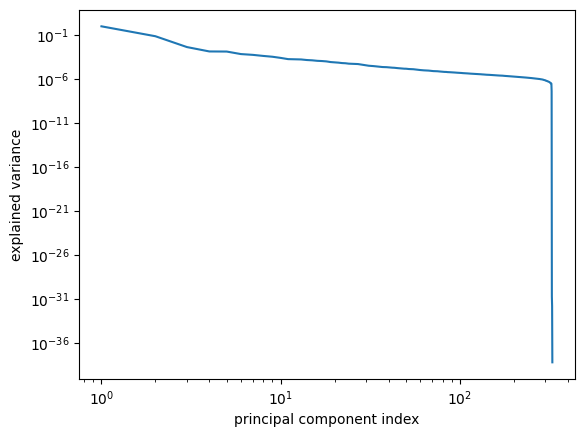

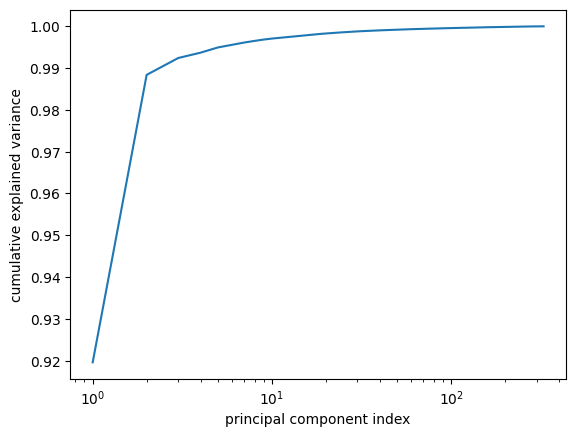

In [7]:
n_components = pca.components_.shape[0]

plt.plot(range(1, n_components+1), pca.explained_variance_ratio_)
plt.xlabel('principal component index')
plt.ylabel('explained variance')
plt.yscale('log')
plt.xscale('log')
plt.show()

plt.plot(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('principal component index')
plt.ylabel('cumulative explained variance')
plt.xscale('log')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


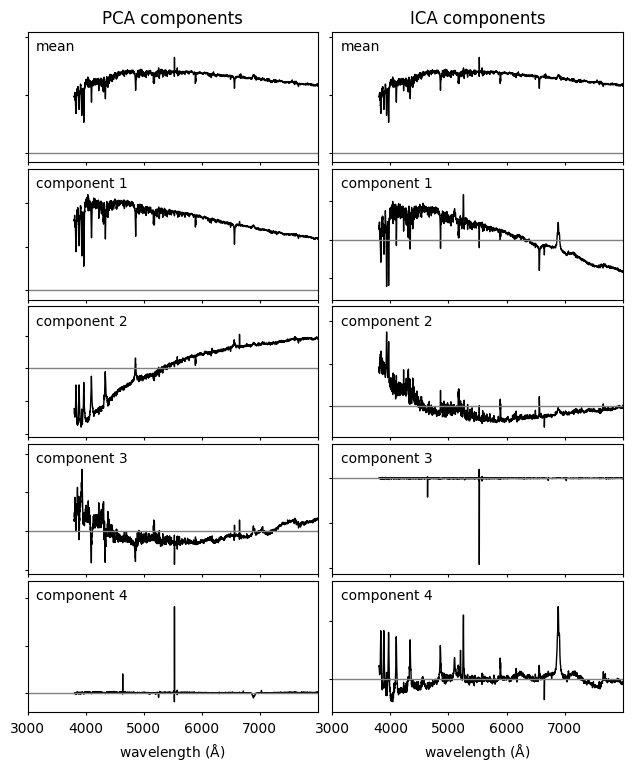

In [8]:
spectra = interpolated_spectra
wavelengths = lambda_[0]

#----------------------------------------------------------------------
# Compute PCA, ICA, and NMF components
def compute_PCA_ICA_NMF(n_components=5):
    spec_mean = np.array(spectra).mean(0)

    # PCA:
    pca = PCA(n_components - 1, random_state=0, svd_solver='randomized')
    pca.fit(spectra)
    pca_comp = np.vstack([spec_mean,
                          pca.components_])

    # ICA treats sequential observations as related.  Because of this, we need
    # to fit with the transpose of the spectra
    ica = FastICA(n_components - 1, random_state=0)
    ica.fit(np.array(spectra).T)
    ica_comp = np.vstack([spec_mean,
                          ica.transform(np.array(spectra).T).T])



    return pca_comp, ica_comp

n_components = 5
decompositions = compute_PCA_ICA_NMF(n_components)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = ['PCA components', 'ICA components']

for i, comp in enumerate(decompositions):
    for j in range(n_components):
        ax = fig.add_subplot(n_components, 3, 3 * j + 1 + i)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.xaxis.set_major_locator(
                plt.FixedLocator(list(range(3000, 7999, 1000))))
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

        ax.plot(wavelengths, comp[j], '-k', lw=1)

        # plot zero line
        xlim = [3000, 8000]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)

        if j == 0:
            ax.set_title(titles[i])

        if titles[i].startswith('PCA') or titles[i].startswith('ICA'):
            if j == 0:
                label = 'mean'
            else:
                label = 'component %i' % j
        else:
            label = 'component %i' % (j + 1)

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines():
            l.set_markersize(2)

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])

        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)
        ax.set_xlim(xlim)


plt.show()

In [9]:
g_r = np.array(g_r)
spec= spectra
def compute_spec_LLE(n_neighbors=10, out_dim=3):
    # Compute the LLE projection
    LLE = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors,
                                          n_components=out_dim,
                                          method='modified',
                                          eigen_solver='dense')
    Y_LLE = LLE.fit_transform(spec)
    print (" - finished LLE projection")

    # remove outliers for the plot
    BT = neighbors.BallTree(Y_LLE)
    dist, ind = BT.query(Y_LLE, n_neighbors)
    dist_to_n = dist[:, -1]
    dist_to_n -= dist_to_n.mean()
    std = np.std(dist_to_n)
    flag = (dist_to_n > 0.25 * std)
    print (" - removing %i outliers for plot" % flag.sum())

    Y_LLE_filtered = Y_LLE[~flag]
    g_r_filtered = g_r[~flag]

    return Y_LLE_filtered, g_r_filtered

coeffs_LLE, g_r_LLE = compute_spec_LLE(10, 3)


 - finished LLE projection
 - removing 43 outliers for plot


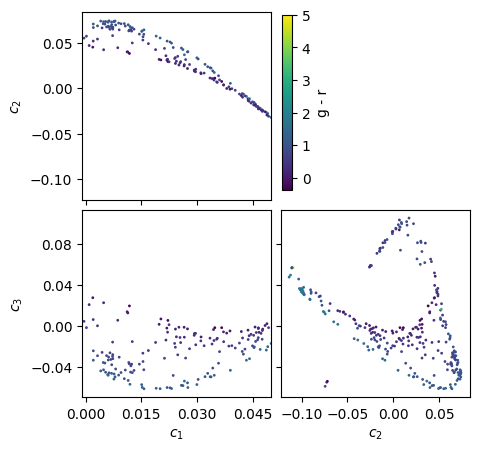

In [10]:
g_r_lim = (min(g_r_LLE), max(g_r_LLE))
g_r_cmap = plt.cm.viridis
plt.rcParams['text.usetex'] = False
for (g_r_values, coeffs, xlim) in zip([g_r_LLE], [coeffs_LLE], [(-0.001, 0.05)]):

    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # Axes for colorbar
    cax = plt.axes([0.525, 0.525, 0.02, 0.35])

    # Create scatter-plots
    scatter_kwargs = dict(s=4, lw=0, edgecolors='none', c=g_r_values, cmap=g_r_cmap)

    ax1 = plt.subplot(221)
    im1 = ax1.scatter(coeffs[:, 0], coeffs[:, 1], **scatter_kwargs)
    im1.set_clim(g_r_lim)
    ax1.set_ylabel('$c_2$')

    ax2 = plt.subplot(223)
    im2 = ax2.scatter(coeffs[:, 0], coeffs[:, 2], **scatter_kwargs)
    im2.set_clim(g_r_lim)
    ax2.set_xlabel('$c_1$')
    ax2.set_ylabel('$c_3$')

    ax3 = plt.subplot(224)
    im3 = ax3.scatter(coeffs[:, 1], coeffs[:, 2], **scatter_kwargs)
    im3.set_clim(g_r_lim)
    ax3.set_xlabel('$c_2$')


    fig.colorbar(im3, ax=ax3, cax=cax, orientation='vertical')

    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax3.yaxis.set_major_formatter(plt.NullFormatter())

    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)
    cbar = fig.colorbar(im3, ax=ax3, cax=cax, orientation='vertical')
    cbar.set_label('g - r')
    for ax in (ax1, ax2, ax3):
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()
